# Interaction Effects & Non-linearity

**Business Question**: Does the effect of diamond cut quality depend on carat size?

This notebook demonstrates interaction effects in regression, showing how the relationship between variables can change depending on the values of other variables, and how to detect and model these complex relationships.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand what interaction effects are and why they matter
- Create and interpret interaction terms in regression models
- Visualize interaction effects using 3D plots and slices
- Detect non-linear relationships in your data
- Choose between linear and polynomial models
- Interpret complex regression coefficients


In [10]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


Dataset shape: (53940, 10)

First 5 rows:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

Cut quality mapping: {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
Cut distribution:
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64


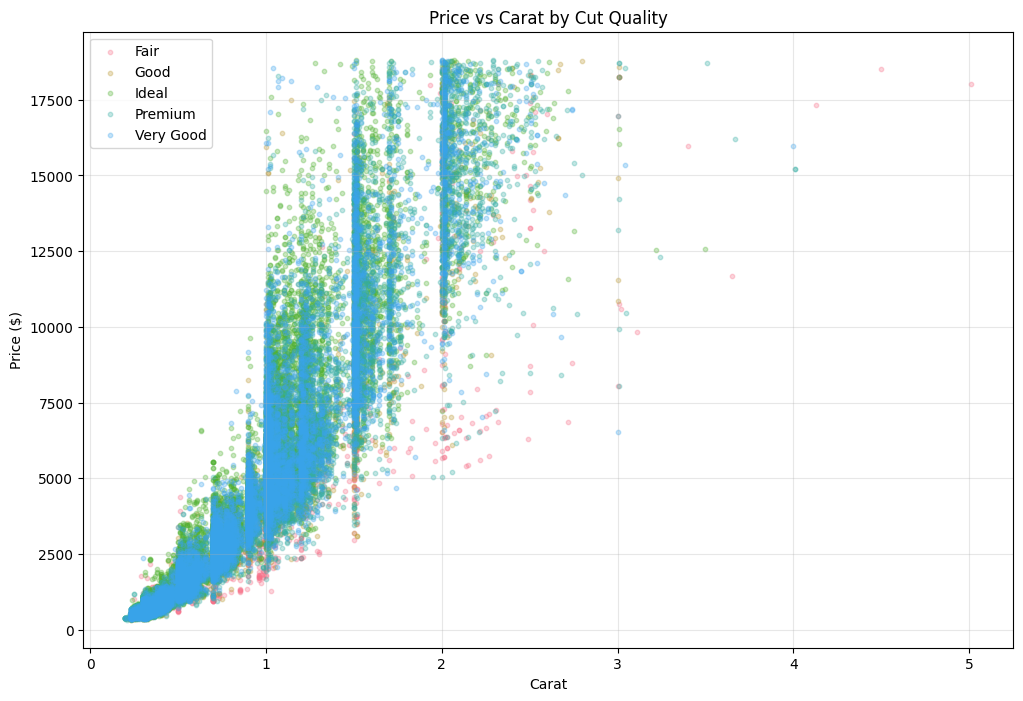

In [11]:
# Load diamonds dataset
diamonds = sns.load_dataset('diamonds')

print("Dataset shape:", diamonds.shape)
print("\nFirst 5 rows:")
print(diamonds.head())

# Focus on key variables for interaction analysis
diamonds_subset = diamonds[['carat', 'cut', 'price']].copy()

# Create ordinal encoding for cut quality
cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
diamonds_subset['cut_ordinal'] = diamonds_subset['cut'].map(cut_mapping)

print(f"\nCut quality mapping: {cut_mapping}")
print(f"Cut distribution:")
print(diamonds_subset['cut'].value_counts().sort_index())

# Show relationship between carat and price by cut quality
plt.figure(figsize=(12, 8))

# Scatter plot with different colors for each cut quality
for cut_level in sorted(diamonds_subset['cut'].unique()):
    subset = diamonds_subset[diamonds_subset['cut'] == cut_level]
    plt.scatter(subset['carat'], subset['price'], alpha=0.3, label=f'{cut_level}', s=10)

plt.xlabel('Carat')
plt.ylabel('Price ($)')
plt.title('Price vs Carat by Cut Quality')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Model 1: No Interaction (Additive Effects)


Model 1: No Interaction (Additive Effects)
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 6.437e+04
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:19:29   Log-Likelihood:            -4.7142e+05
No. Observations:               53940   AIC:                         9.429e+05
Df Residuals:                   53934   BIC:                         9.429e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

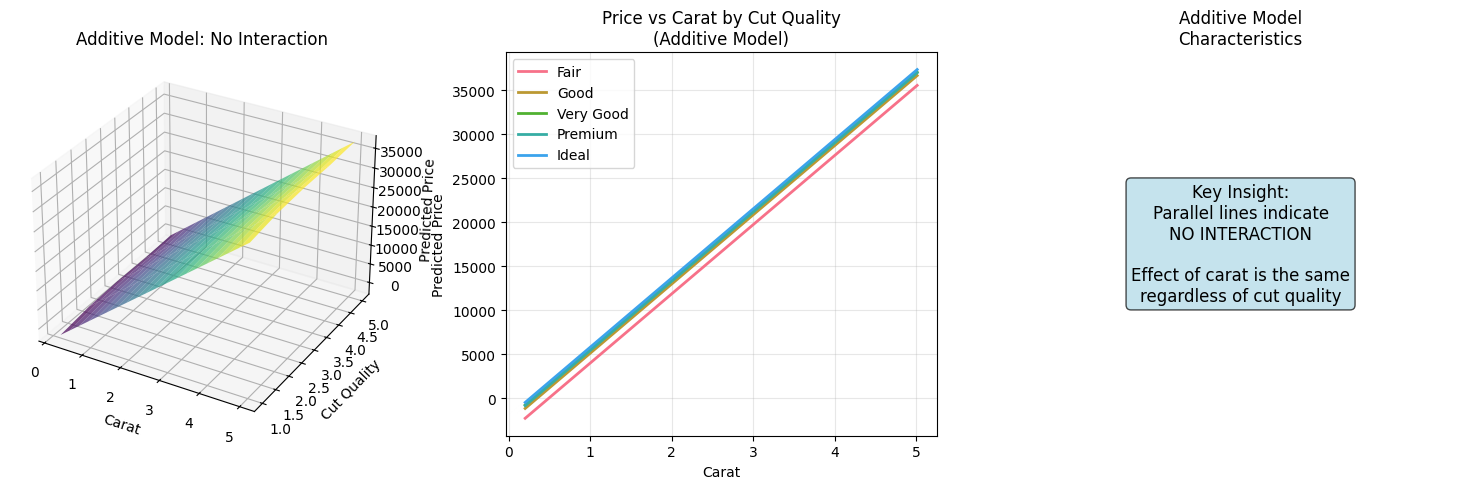

In [12]:
# Model without interaction (additive effects)
model_no_interaction = ols("price ~ carat + cut_ordinal", data=diamonds_subset).fit()

print("Model 1: No Interaction (Additive Effects)")
print("="*50)
print(model_no_interaction.summary())

print("\nInterpretation:")
print(f"Carat coefficient: {model_no_interaction.params['carat']:.2f}")
print("  → Each additional carat increases price by this amount, regardless of cut quality")

# Check what cut-related coefficients exist
cut_coefs = [col for col in model_no_interaction.params.index if 'cut_ordinal' in col]
print(f"\nCut coefficients (dummy variables):")
for coef in cut_coefs:
    level = coef.split('[')[1].split(']')[0] if '[' in coef else 'baseline'
    print(f"  {coef}: {model_no_interaction.params[coef]:.2f}")
print("  → Each coefficient shows the effect relative to the baseline cut level")

# Visualize the additive model
fig = plt.figure(figsize=(15, 5))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')

# Create a grid for visualization
carat_range = np.linspace(diamonds_subset['carat'].min(), diamonds_subset['carat'].max(), 20)
cut_range = [1, 2, 3, 4, 5]  # Use discrete cut levels
Carat, Cut = np.meshgrid(carat_range, cut_range)

# Predictions for the grid
grid_data = pd.DataFrame({
    'carat': Carat.ravel(),
    'cut_ordinal': Cut.ravel()
})
predictions = model_no_interaction.predict(grid_data)
Predictions = predictions.values.reshape(Carat.shape)

# Plot the surface
surf = ax1.plot_surface(Carat, Cut, Predictions, alpha=0.7, cmap='viridis')
ax1.set_xlabel('Carat')
ax1.set_ylabel('Cut Quality')
ax1.set_zlabel('Predicted Price')
ax1.set_title('Additive Model: No Interaction')

# 2D slices for different cut qualities
ax2 = fig.add_subplot(132)
cut_levels = [1, 2, 3, 4, 5]
cut_names = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

for i, (cut_val, cut_name) in enumerate(zip(cut_levels, cut_names)):
    # Create data for this cut level
    slice_data = pd.DataFrame({
        'carat': carat_range,
        'cut_ordinal': [cut_val] * len(carat_range)
    })
    slice_predictions = model_no_interaction.predict(slice_data)
    
    ax2.plot(carat_range, slice_predictions, label=f'{cut_name}', linewidth=2)

ax2.set_xlabel('Carat')
ax2.set_ylabel('Predicted Price')
ax2.set_title('Price vs Carat by Cut Quality\n(Additive Model)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Show the parallel lines (no interaction)
ax3 = fig.add_subplot(133)
ax3.text(0.5, 0.5, 'Key Insight:\nParallel lines indicate\nNO INTERACTION\n\nEffect of carat is the same\nregardless of cut quality', 
         ha='center', va='center', fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')
ax3.set_title('Additive Model\nCharacteristics')

plt.tight_layout()
plt.show()


## Model 2: With Interaction Effects


Model 2: With Interaction Effects
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:19:30   Log-Likelihood:            -4.7093e+05
No. Observations:               53940   AIC:                         9.419e+05
Df Residuals:                   53930   BIC:                         9.420e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

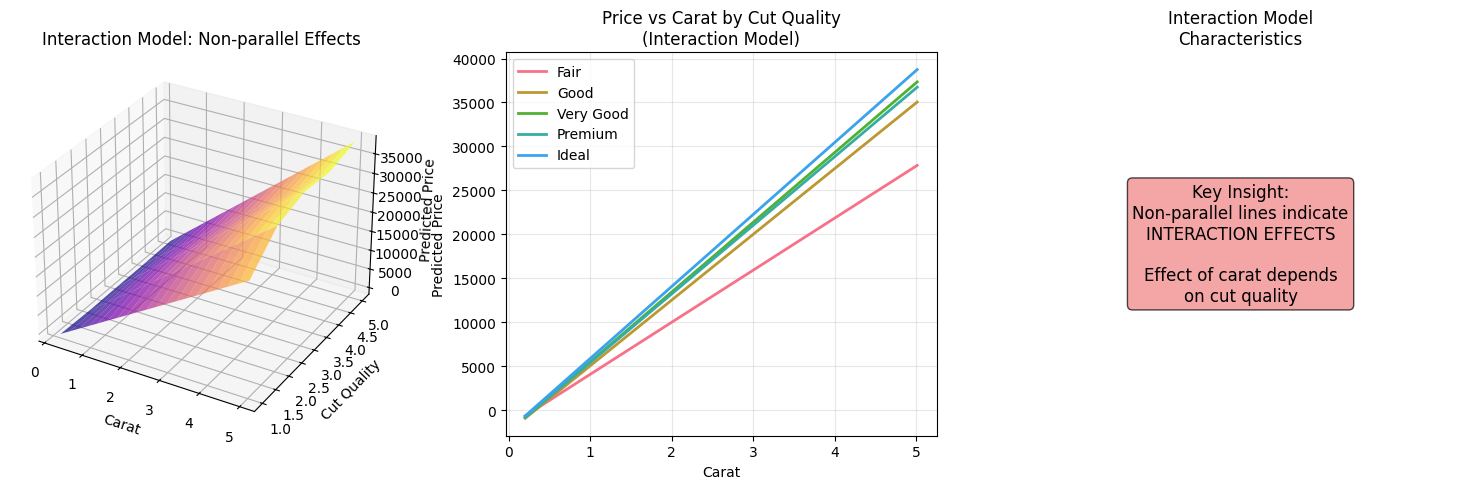

In [13]:
# Model with interaction (carat * cut_ordinal)
model_with_interaction = ols("price ~ carat + cut_ordinal + carat:cut_ordinal", data=diamonds_subset).fit()

print("Model 2: With Interaction Effects")
print("="*50)
print(model_with_interaction.summary())

print("\nInterpretation:")
print(f"Carat coefficient: {model_with_interaction.params['carat']:.2f}")
print("  → Effect of carat when cut_ordinal = baseline level")

# Check what cut-related coefficients exist
cut_coefs = [col for col in model_with_interaction.params.index if 'cut_ordinal' in col and ':' not in col]
print(f"\nCut coefficients (main effects):")
for coef in cut_coefs:
    level = coef.split('[')[1].split(']')[0] if '[' in coef else 'baseline'
    print(f"  {coef}: {model_with_interaction.params[coef]:.2f}")

# Check interaction coefficients
interaction_coefs = [col for col in model_with_interaction.params.index if 'carat:cut_ordinal' in col]
print(f"\nInteraction coefficients:")
for coef in interaction_coefs:
    level = coef.split('[')[1].split(']')[0] if '[' in coef else 'baseline'
    print(f"  {coef}: {model_with_interaction.params[coef]:.2f}")
    print(f"    → How much the carat effect changes for cut level {level}")

# Visualize the interaction model
fig = plt.figure(figsize=(15, 5))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')

# Create a grid for visualization
carat_range = np.linspace(diamonds_subset['carat'].min(), diamonds_subset['carat'].max(), 20)
cut_range = [1, 2, 3, 4, 5]  # Use discrete cut levels
Carat, Cut = np.meshgrid(carat_range, cut_range)

# Predictions for the grid
grid_data = pd.DataFrame({
    'carat': Carat.ravel(),
    'cut_ordinal': Cut.ravel()
})
predictions = model_with_interaction.predict(grid_data)
Predictions = predictions.values.reshape(Carat.shape)

# Plot the surface
surf = ax1.plot_surface(Carat, Cut, Predictions, alpha=0.7, cmap='plasma')
ax1.set_xlabel('Carat')
ax1.set_ylabel('Cut Quality')
ax1.set_zlabel('Predicted Price')
ax1.set_title('Interaction Model: Non-parallel Effects')

# 2D slices for different cut qualities
ax2 = fig.add_subplot(132)
cut_levels = [1, 2, 3, 4, 5]
cut_names = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

for i, (cut_val, cut_name) in enumerate(zip(cut_levels, cut_names)):
    # Create data for this cut level
    slice_data = pd.DataFrame({
        'carat': carat_range,
        'cut_ordinal': [cut_val] * len(carat_range)
    })
    slice_predictions = model_with_interaction.predict(slice_data)
    
    ax2.plot(carat_range, slice_predictions, label=f'{cut_name}', linewidth=2)

ax2.set_xlabel('Carat')
ax2.set_ylabel('Predicted Price')
ax2.set_title('Price vs Carat by Cut Quality\n(Interaction Model)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Show the non-parallel lines (interaction)
ax3 = fig.add_subplot(133)
ax3.text(0.5, 0.5, 'Key Insight:\nNon-parallel lines indicate\nINTERACTION EFFECTS\n\nEffect of carat depends\non cut quality', 
         ha='center', va='center', fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')
ax3.set_title('Interaction Model\nCharacteristics')

plt.tight_layout()
plt.show()


## Non-linearity Detection


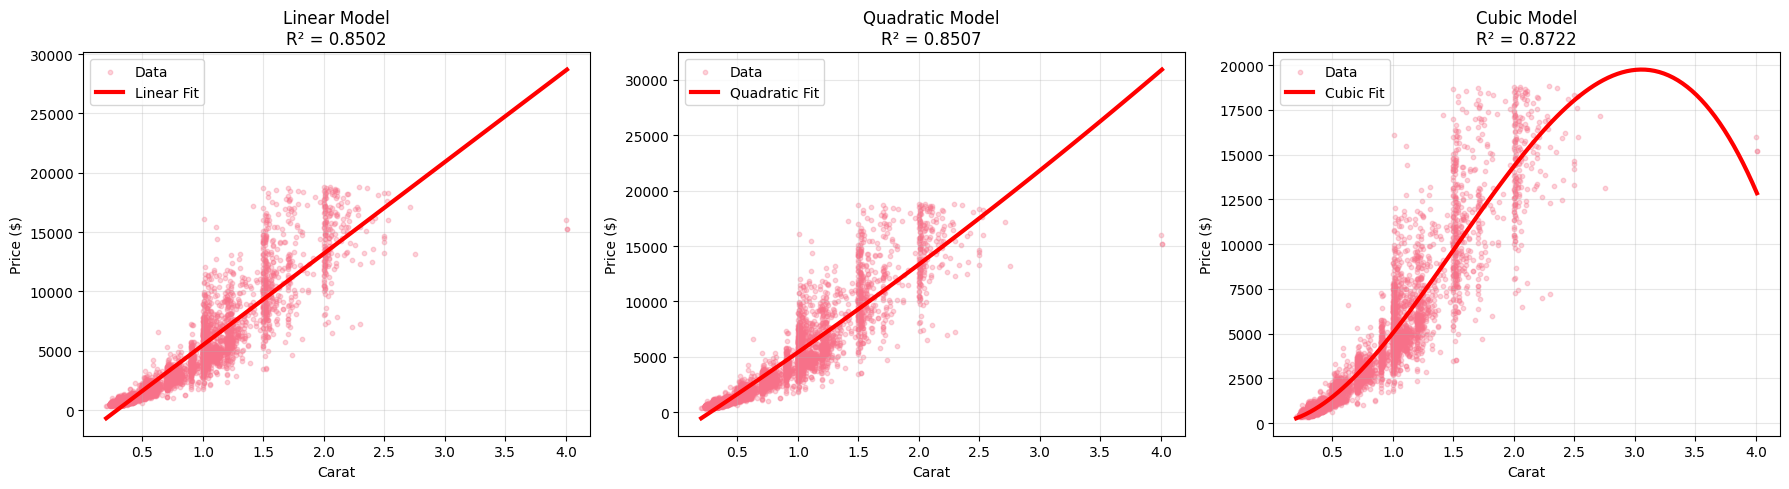


Non-linearity Comparison:
Model           Degree     R²         MSE            
--------------------------------------------------
Linear          1          0.8502     2449937.52     
Quadratic       2          0.8507     2441022.99     
Cubic           3          0.8722     2089600.63     

Conclusion: Non-linear (polynomial) models capture the relationship better!


In [14]:
# Detect non-linearity using polynomial features
# Sample subset for computational efficiency
diamonds_sample = diamonds_subset.sample(n=5000, random_state=42)

# Prepare data
X = diamonds_sample[['carat']].values
y = diamonds_sample['price'].values

# Fit models of different complexity
models = {
    'Linear': 1,
    'Quadratic': 2,
    'Cubic': 3
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results = {}

for idx, (name, degree) in enumerate(models.items()):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predictions
    X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_pred = model.predict(X_plot_poly)
    
    # Calculate metrics
    y_train_pred = model.predict(X_poly)
    r2 = r2_score(y, y_train_pred)
    mse = mean_squared_error(y, y_train_pred)
    
    results[name] = {'R²': r2, 'MSE': mse, 'Degree': degree}
    
    # Plot
    axes[idx].scatter(X, y, alpha=0.3, s=10, label='Data')
    axes[idx].plot(X_plot, y_pred, 'r-', linewidth=3, label=f'{name} Fit')
    axes[idx].set_xlabel('Carat')
    axes[idx].set_ylabel('Price ($)')
    axes[idx].set_title(f'{name} Model\nR² = {r2:.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("\nNon-linearity Comparison:")
print("="*50)
print(f"{'Model':<15} {'Degree':<10} {'R²':<10} {'MSE':<15}")
print("-"*50)
for name, metrics in results.items():
    print(f"{name:<15} {metrics['Degree']:<10} {metrics['R²']:<10.4f} {metrics['MSE']:<15.2f}")

print("\nConclusion: Non-linear (polynomial) models capture the relationship better!")


## Model Comparison

### Additive vs Interaction Models


In [15]:
# Compare models
print("MODEL COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'No Interaction':<20} {'With Interaction':<20}")
print("-"*60)
print(f"{'R-squared':<25} {model_no_interaction.rsquared:<20.4f} {model_with_interaction.rsquared:<20.4f}")
print(f"{'Adjusted R-squared':<25} {model_no_interaction.rsquared_adj:<20.4f} {model_with_interaction.rsquared_adj:<20.4f}")
print(f"{'AIC':<25} {model_no_interaction.aic:<20.2f} {model_with_interaction.aic:<20.2f}")
print(f"{'BIC':<25} {model_no_interaction.bic:<20.2f} {model_with_interaction.bic:<20.2f}")
print(f"{'Parameters':<25} {len(model_no_interaction.params):<20} {len(model_with_interaction.params):<20}")

# Determine which model is better
if model_with_interaction.aic < model_no_interaction.aic:
    print("\n✓ Interaction model is BETTER (lower AIC)")
    print("  → The effect of carat DOES depend on cut quality")
else:
    print("\n✗ Additive model is sufficient")
    print("  → The effect of carat does NOT depend on cut quality")

# Calculate improvement
improvement = (model_with_interaction.rsquared - model_no_interaction.rsquared) / model_no_interaction.rsquared * 100
print(f"\nR² improvement: {improvement:.2f}%")


MODEL COMPARISON
Metric                    No Interaction       With Interaction    
------------------------------------------------------------
R-squared                 0.8565               0.8591              
Adjusted R-squared        0.8565               0.8590              
AIC                       942852.23            941878.10           
BIC                       942905.60            941967.05           
Parameters                6                    10                  

✓ Interaction model is BETTER (lower AIC)
  → The effect of carat DOES depend on cut quality

R² improvement: 0.30%


## Key Takeaways

### **Interaction Effects:**

1. **Definition**: When the effect of one variable depends on another variable
2. **Detection**: Look for non-parallel lines in visualizations
3. **Modeling**: Include interaction terms (e.g., `carat:cut_ordinal`)
4. **Interpretation**: More complex but captures real relationships

### **Non-linearity:**

1. **Polynomial models** can capture curved relationships
2. **Compare models** using R², AIC, BIC
3. **Balance complexity** vs interpretability
4. **Visualize** to understand the relationships

### **When to Include Interactions:**

- When theory suggests the relationship should vary
- When visualizations show non-parallel patterns
- When interaction term is statistically significant
- When model fit substantially improves

### **Business Impact:**

- **Better predictions** by capturing complex relationships
- **Deeper insights** into how variables work together
- **More realistic models** that match real-world behavior
- **Improved decision-making** with accurate understanding
